## Problem Statement

Analyze non-emergency 'Housing and Building' complaints reported to the 311 system in NY.<br>
__(1) Determine which type of complaint is the most common.<br>
(2) Where is this type of complaint more concentrated.<br>
(3) Determine if there is an obvious house/building characteristic that can help predict this particular type of complaint.<br>
(4) Build a model that can predict this type of complaints based on house/building characteristics.__

### Datasets

__311 complaint dataset__
This dataset 'Department of Housing Preservation and Development' is available at https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9.

__PLUTO - Primary Land Use Tax Lot Output__
This dataset for housing can be accessed from https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf.

### (1) Most Common Type of Complaint

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import time
import seaborn as sns

In case you don't want to download the file directly from the source, you can download mine here:
https://www.dropbox.com/s/jaiysnr3vntizrs/fhrw-4uyv.csv?dl=0

In [2]:
#Loading file... as a reference it takes 21 seconds in my computer
start=time.time()
df=pd.read_csv('fhrw-4uyv.csv',parse_dates=True)
print('Time loading:',time.time()-start)

Time loading: 18.717325925827026


In [3]:
df.head(5)

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2018-08-28T14:29:05.000,40125735,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The literature will be emailed within 24 hours...,Unspecified,NaN,NaN,2018-08-29T14:32:47.000,NaN,Closed
1,2019-03-29T13:39:15.000,42089776,PLUMBING,10030.0,2312 ADAM C POWELL BOULEVARD,ADAM C POWELL BOULEVARD,ADDRESS,NEW YORK,The Department of Housing Preservation and Dev...,MANHATTAN,40.815723,-73.943407,2019-04-04T12:44:34.000,RESIDENTIAL BUILDING,Closed
2,2019-03-29T12:39:24.000,42089777,DOOR/WINDOW,10021.0,1404 YORK AVENUE,YORK AVENUE,ADDRESS,NEW YORK,The Department of Housing Preservation and Dev...,MANHATTAN,40.768572,-73.952479,2019-04-04T21:04:49.000,RESIDENTIAL BUILDING,Closed
3,2019-03-29T08:52:02.000,42090351,HEAT/HOT WATER,10471.0,215 WEST 242 STREET,WEST 242 STREET,ADDRESS,BRONX,The complaint you filed is a duplicate of a co...,BRONX,40.889564,-73.899050,2019-04-01T02:07:40.000,RESIDENTIAL BUILDING,Closed
4,2019-02-05T08:20:59.000,41645420,APPLIANCE,10459.0,1211 SOUTHERN BOULEVARD,SOUTHERN BOULEVARD,ADDRESS,BRONX,The Department of Housing Preservation and Dev...,BRONX,40.828949,-73.891897,2019-03-29T10:46:40.000,RESIDENTIAL BUILDING,Closed


#### Data Wrangling

In [4]:
#Trying to understand the information...
print ('Rows:',df.shape[0],'\tColumns: ',df.shape[1],'\n')
print(df.dtypes)

Rows: 5805405 	Columns:  15 

created_date               object
unique_key                  int64
complaint_type             object
incident_zip              float64
incident_address           object
street_name                object
address_type               object
city                       object
resolution_description     object
borough                    object
latitude                  float64
longitude                 float64
closed_date                object
location_type              object
status                     object
dtype: object


Need to change zipcode to string because I am going to use it as a label.

In [5]:
df.isna().sum()

created_date                   0
unique_key                     0
complaint_type                 0
incident_zip               81944
incident_address           54197
street_name                54197
address_type               79041
city                       81543
resolution_description      6066
borough                        0
latitude                   81918
longitude                  81918
closed_date               124742
location_type              54196
status                         0
dtype: int64

Why are there are __'NaN'/null__ values in the address and zip?

In [6]:
df[df['incident_address'].isnull()].head(5)

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2018-08-28T14:29:05.000,40125735,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The literature will be emailed within 24 hours...,Unspecified,NaN,NaN,2018-08-29T14:32:47.000,NaN,Closed
171,2018-12-19T17:20:35.000,41225860,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The appropriate agency will fulfill this liter...,Unspecified,NaN,NaN,NaN,NaN,Open
399,2018-12-19T12:39:47.000,41227022,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The literature will be emailed within 24 hours...,Unspecified,NaN,NaN,2018-12-20T12:42:08.000,NaN,Closed
488,2019-03-30T00:27:44.000,42085882,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The appropriate agency will fulfill this liter...,Unspecified,NaN,NaN,NaN,NaN,Open
525,2018-08-29T11:57:27.000,40137418,HPD Literature Request,NaN,NaN,NaN,NaN,NaN,The literature has been mailed. If it has not ...,Unspecified,NaN,NaN,2018-08-29T14:14:20.000,NaN,Closed


Most of the complaints with NaN values in the incident_address field are related to documentation ('literature request') so I am going to eliminate them because they are not really a complaint. I guess users called to require some information or documentation.<br>
Also since the we will be analyzing complaints related to house/building characteristics we need an address.

In [7]:
print('Rows before: ',df.shape[0])
df.dropna(subset = ['incident_address','incident_zip'], inplace=True)
print('Rows after eliminating NaNs: ',df.shape[0])
df.isna().sum()

Rows before:  5805405
Rows after eliminating NaNs:  5723461


created_date                   0
unique_key                     0
complaint_type                 0
incident_zip                   0
incident_address               0
street_name                    0
address_type                   0
city                           0
resolution_description       591
borough                        0
latitude                       0
longitude                      0
closed_date               121869
location_type                  0
status                         0
dtype: int64

We __dropped 82k rows from 6 million.__<br>
Now, the only rows with NaNs (empty values) are because they have an 'open' status or don't have a resolution_description. __It is ok.__

In [8]:
#changing zipcodes to text in 2 steps (first to integer to remove 0's, then to string)
df.incident_zip=df.incident_zip.astype('int')
df.incident_zip=df.incident_zip.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5723461 entries, 1 to 5805404
Data columns (total 15 columns):
created_date              object
unique_key                int64
complaint_type            object
incident_zip              object
incident_address          object
street_name               object
address_type              object
city                      object
resolution_description    object
borough                   object
latitude                  float64
longitude                 float64
closed_date               object
location_type             object
status                    object
dtypes: float64(2), int64(1), object(12)
memory usage: 698.7+ MB


Now lets remove the double spaces and tabs from the incident_address and street_name fields.

In [9]:
#remove spaces and tabs from incident_address. Displaying amount of deleted/remaining rows
before_incident=df['incident_address'].nunique()
before_street_name=df['street_name'].nunique()
df.incident_address = df.incident_address.replace('\s+', ' ', regex=True) 
df.incident_address = df.incident_address.str.strip()
df.street_name = df.street_name.replace('\s+', ' ', regex=True) 
df.street_name = df.street_name.str.strip()
print('incident_address: ',before_incident,'-',df['incident_address'].nunique(),'=',before_incident-df['incident_address'].nunique())
print('street_name: ',before_street_name,'-',df['street_name'].nunique(),'=',before_street_name-df['street_name'].nunique())

incident_address:  175075 - 161622 = 13453
street_name:  6480 - 5809 = 671


I will also be abbreviating some of the most common words in the street names that can help me keep everything standardized.<br>
__This process helped me match around 40k more addresses later with the PLUTO dataframe.__

In [10]:
#will be substituting Avenue for Ave, Street for St, Place for Pl, Road for Rd and Boulevard for Blvd
df.incident_address = df.incident_address.str.replace('AVENUE','AVE')
df.incident_address = df.incident_address.str.replace('STREET','ST')
df.incident_address = df.incident_address.str.replace('PLACE','PL')
df.incident_address = df.incident_address.str.replace('ROAD','RD')
df.incident_address = df.incident_address.str.replace('BOULEVARD','BLVD')
#will be substituting East for E, West for W, North for N and South for S. This changes will happen
#   only if it is a separate word or if the address ends with it.
# Example: 'Central Park West' will change to 'Central Park W' but if the name of the street is
#   'Northeast Street' it will not change to 'NE Street'
df.incident_address = df.incident_address.str.replace(' EAST ',' E ')
df.incident_address = df.incident_address.str.replace(' EAST',' E')
df.incident_address = df.incident_address.str.replace(' WEST ',' W ')
df.incident_address = df.incident_address.str.replace(' WEST',' W')
df.incident_address = df.incident_address.str.replace(' NORTH ',' N ')
df.incident_address = df.incident_address.str.replace(' NORTH',' N')
df.incident_address = df.incident_address.str.replace(' SOUTH ',' S ')
df.incident_address = df.incident_address.str.replace(' SOUTH',' S')

Now, lets analyze the complaint types

In [11]:
#some complaint types look like the same
print(df['complaint_type'].unique())
print('\nTotal: ',df['complaint_type'].nunique())

['PLUMBING' 'DOOR/WINDOW' 'HEAT/HOT WATER' 'APPLIANCE' 'ELECTRIC'
 'FLOORING/STAIRS' 'UNSANITARY CONDITION' 'PAINT/PLASTER' 'GENERAL'
 'WATER LEAK' 'SAFETY' 'OUTSIDE BUILDING' 'ELEVATOR' 'HEATING'
 'PAINT - PLASTER' 'GENERAL CONSTRUCTION' 'NONCONST' 'CONSTRUCTION'
 'STRUCTURAL' 'VACANT APARTMENT' 'AGENCY']

Total:  21


Some complaints like 'paint/plaster' and 'paint - plaster' are evidently the same. Also, 'construction' and 'general construction' and 'general' can be classified the same.<br>
Other, such as 'Heating' and 'Heat/Hot Water' look like the same but we need to review them with more detail. 

In [12]:
print('HEATING: ',df.created_date[df.complaint_type== 'HEATING'].min(),' ---> ',df.created_date[df.complaint_type== 'HEATING'].max())
print('HEAT/HOT WATER: ',df.created_date[df.complaint_type== 'HEAT/HOT WATER'].min(),' ---> ',df.created_date[df.complaint_type== 'HEAT/HOT WATER'].max())

HEATING:  2010-01-01T00:00:00.000  --->  2014-03-10T00:00:00.000
HEAT/HOT WATER:  2014-03-11T00:00:00.000  --->  2019-06-21T22:51:54.000


__It looks like 'Heating' and 'Heat/Hot Water' are the same, they just started using the new name in March 2014.__

In [13]:
#consolidating the complaint types mentioned above
df['complaint_type'].replace('HEAT/HOT WATER','HEATING',inplace=True)
df['complaint_type'].replace('PAINT - PLASTER','PAINT/PLASTER',inplace=True)
df['complaint_type'].replace('GENERAL CONSTRUCTION','CONSTRUCTION',inplace=True)
df['complaint_type'].replace('GENERAL','CONSTRUCTION',inplace=True)
print(df['complaint_type'].unique())
print('Total: ',df['complaint_type'].nunique())

['PLUMBING' 'DOOR/WINDOW' 'HEATING' 'APPLIANCE' 'ELECTRIC'
 'FLOORING/STAIRS' 'UNSANITARY CONDITION' 'PAINT/PLASTER' 'CONSTRUCTION'
 'WATER LEAK' 'SAFETY' 'OUTSIDE BUILDING' 'ELEVATOR' 'NONCONST'
 'STRUCTURAL' 'VACANT APARTMENT' 'AGENCY']
Total:  17


In [14]:
#making a group to visualize it better
df_grp_complaint=df.complaint_type.value_counts().to_frame()
df_grp_complaint.reset_index(drop=False,inplace=True) #resetting the index
df_grp_complaint.rename(columns={'complaint_type':'total','index':'complaint'},inplace=True) #renaming the columns
df_grp_complaint

,complaint,total
0,HEATING,2014528
1,PAINT/PLASTER,696919
2,PLUMBING,695689
3,CONSTRUCTION,647221
4,UNSANITARY CONDITION,425585
5,ELECTRIC,299491
6,NONCONST,259999
7,DOOR/WINDOW,196673
8,WATER LEAK,183548
9,FLOORING/STAIRS,133763


Text(0.5, 1.0, 'Complaints by Type')

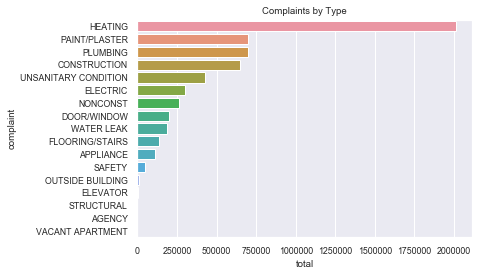

In [15]:
import seaborn as sns
sns.set(font_scale=.8)
sns.barplot(x='total',y='complaint',data=df_grp_complaint).set_title('Complaints by Type')

In [16]:
print('Heating complaints:',df_grp_complaint.total[df_grp_complaint.complaint == 'HEATING'][0])
print('Heating complaints as percentage:',int(100*df_grp_complaint.total[df_grp_complaint.complaint == 'HEATING'][0] /df_grp_complaint['total'].sum()),'%')

Heating complaints: 2014528
Heating complaints as percentage: 35 %


#### Conclusion: The most common type of complaint is 'Heating'. It has more than 35% of the total complaints and it has more than double than the next complaint: Paint/Plaster.

### (2) Where is this type of complaint more concentrated.

__I will focus in Heating type.__

First, analyzing the information by borough.

In [17]:
df.columns

Index(['created_date', 'unique_key', 'complaint_type', 'incident_zip',
       'incident_address', 'street_name', 'address_type', 'city',
       'resolution_description', 'borough', 'latitude', 'longitude',
       'closed_date', 'location_type', 'status'],
      dtype='object')

In [18]:
df.drop(['unique_key'], axis=1, inplace=True) #deleting column I won't be needing
df.borough.value_counts()

BROOKLYN         1664999
BRONX            1539546
MANHATTAN        1002197
Unspecified       819798
QUEENS            612945
STATEN ISLAND      83976
Name: borough, dtype: int64

With the previous table I realized that there are a lot of boroughs with the label "Unspecified".<br>
To change this, I will be creating a catalog with valid zipcodes-boroughs from the same dataset to see if I can remove some of the 'Unspecified' ones.

In [19]:
df_zip=df[['borough','incident_zip']].copy() #1st create new dataframe with 2 columns
df_zip = df_zip[df.borough != 'Unspecified'] #removing all the Unspecified boroughs
df_zip['count']=1 #adding a column with 1's so I can sum/count them
df_zip=df_zip.groupby(['incident_zip','borough'], as_index=False, sort=True, group_keys=True).sum() #grouping
print('Size catalog :',df_zip.shape[0])
print('Different rows: ',df_zip.incident_zip.nunique())

Size catalog : 203
Different rows:  201


There are duplicates in my catalog, I will be removing the duplicated ones but I will keep the one with more 'hits'.

In [20]:
df_zip.sort_values('count', ascending=False, inplace=True)  #sorting list by 'hits'
df_zip.reset_index(drop=True,inplace=True)
df_zip.drop_duplicates(subset ='incident_zip', keep='first', inplace=True) #keeping the first

In [21]:
print('Size catalog :',df_zip.shape[0])
print('Different rows: ',df_zip.incident_zip.nunique())

Size catalog : 201
Different rows:  201


In [22]:
#with this dataframe I will be making a dictionary
df_zip.drop(['count'], axis=1, inplace=True)
df_zip.set_index('incident_zip',inplace=True)
dict_zips=df_zip.to_dict()
dict_zips=dict_zips['borough']

In [23]:
#will make a new_borough column with borough name, if its 'Unspecified' i will instead put the zipcode
list_zip=list(df['incident_zip'])
list_borough=list(df['borough'])
i=0
for i in range(len(list_borough)):
    if list_borough[i]=='Unspecified':
        list_borough[i]=list_zip[i]
df['new_borough']=list_borough

In [24]:
#printing just the first 10 to make sure the process worked
df.new_borough.value_counts().head(10)

BROOKLYN         1664999
BRONX            1539546
MANHATTAN        1002197
QUEENS            612945
STATEN ISLAND      83976
11226              31946
10467              23026
10453              22747
10458              22664
10457              21276
Name: new_borough, dtype: int64

In [25]:
# substitute the 'Unspecified' rows with data from dictionary
list_borough=list(df['new_borough'])
list_new_borough=list()
for x in list_borough:
    try:
        if x not in ('BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND'):
            list_new_borough.append(dict_zips[x])
        else:
            list_new_borough.append(x)
    except:
        list_new_borough.append(np.NaN)
df['new_borough']=list_new_borough
df.new_borough.value_counts()

BROOKLYN         1960317
BRONX            1791542
MANHATTAN        1155921
QUEENS            717338
STATEN ISLAND      98342
Name: new_borough, dtype: int64

__No more 'Unspecified' boroughs anymore.__

In [26]:
#Lets process only the Heating type of complaints
df_heat=df[df.complaint_type == 'HEATING']
df_grp_borough_heat=df_heat.new_borough.value_counts().to_frame()  #making a dataframe with value_counts
df_grp_borough_heat.reset_index(drop=False,inplace=True)
df_grp_borough_heat.columns

Index(['index', 'new_borough'], dtype='object')

Text(0.5, 1.0, 'Heating Complaints by Borough')

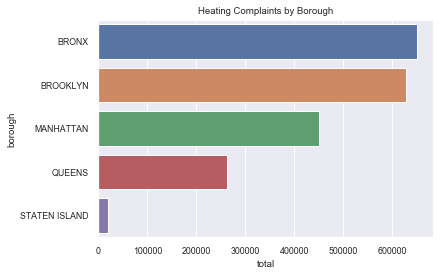

In [27]:
#renaming the grouped dataframe
df_grp_borough_heat.rename(columns={'new_borough':'total','index':'borough'},inplace=True)
#making graph
sns.set(font_scale=0.8)
sns.barplot(x='total', y='borough', data=df_grp_borough_heat).set_title('Heating Complaints by Borough')

__Most of the 'Heating' complaints come from the Bronx, Brooklyn and Manhattan.__

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'Heating Complaints by Borough')

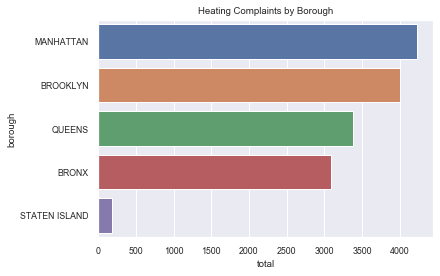

In [28]:
#now doing the same but only for the ones with an 'Open' status
df_heat_open=df[df.complaint_type == 'HEATING']
df_heat_open=df_heat_open[df.status == 'Open']
df_grp_borough_heat=df_heat_open.new_borough.value_counts().to_frame()
df_grp_borough_heat.reset_index(drop=False,inplace=True)
df_grp_borough_heat.rename(columns={'new_borough':'total','index':'borough'},inplace=True)
sns.set(font_scale=0.8)
sns.barplot(x='total', y='borough', data=df_grp_borough_heat).set_title('Heating Complaints by Borough')

__Information changed drastically. Complaints with the open status are more concentrated in Manhattan, Brooklyn and Queens. Bronx this time came in 4th place. Staten Island didn't changed its 5th place.__

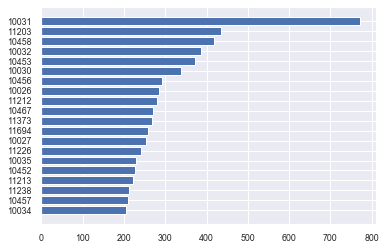

In [29]:
#now by zip codes-only opened ones
#df_heat_open=df[df.complaint_type == 'HEATING']
#df_heat_open=df_heat_open[df.status == 'Open']
#not a lot of information. lets try it by zip code
df_grp_zip_heat=df_heat_open.incident_zip.value_counts().to_frame()
df_grp_zip_heat.reset_index(drop=False,inplace=True)
df_grp_zip_heat.rename(columns={'index':'zipcode','incident_zip':'total'},inplace=True)
df_grp_zip_heat['zipcode'] = df_grp_zip_heat['zipcode'].apply(str)
df_grp_zip_heat=df_grp_zip_heat.head(20).copy()

df_grp_zip_heat.sort_values('total', ascending=True, inplace=True)
w=list(df_grp_zip_heat['zipcode'])
n=list(df_grp_zip_heat['total'])
plt.barh(range(len(w)),n)
plt.yticks(range(len(w)),w)
plt.show()

__Most of the complaints happen in zipcode 10031.__

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Heating Complaints by Street Name (Open Status)')

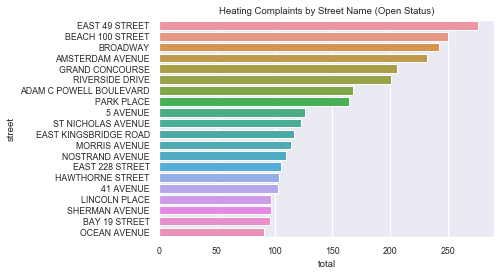

In [30]:
#By street name, only including complaints with 'open' status
df.street_name.value_counts()
df_heat=df[df.complaint_type == 'HEATING']
df_heat=df_heat[df.status == 'Open']

df_grp_street=df_heat.street_name.value_counts().to_frame()

df_grp_street.reset_index(drop=False,inplace=True)
df_grp_street.columns

df_grp_street.rename(columns={'street_name':'total','index':'street'},inplace=True)
df_grp_street

df_grp_street=df_grp_street.head(20)
#import seaborn as sns
sns.set(font_scale=0.8)
sns.barplot(x='total', y='street', data=df_grp_street).set_title('Heating Complaints by Street Name (Open Status)')

Text(0.5, 1.0, 'Heating Complaints by Street (Open Status) - Zipcode 10031')

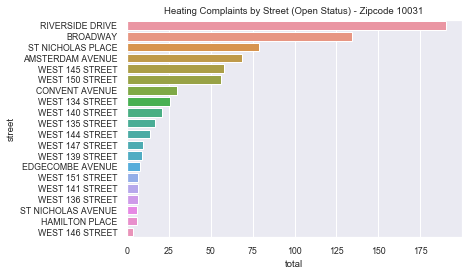

In [31]:
#only focusing on open and zip 10031
df_heat=df.loc[(df['complaint_type'] == 'HEATING') & (df['status'] == 'Open') & (df['incident_zip'] == '10031')]
df_grp_street=df_heat.street_name.value_counts().to_frame()
df_grp_street.reset_index(drop=False,inplace=True)
df_grp_street.rename(columns={'street_name':'total','index':'street'},inplace=True)
df_grp_street=df_grp_street.head(20)
sns.set(font_scale=0.8)
sns.barplot(x='total', y='street', data=df_grp_street).set_title('Heating Complaints by Street (Open Status) - Zipcode 10031')

#### Conclusion: The heating complaints are concentrated in zipcode 10031. A couple of streets, Riverside Drive and Broadway have the most complaints in that zipcode.

### (3) Will try to determine if there is an obvious house/building characteristic that can help predict this particular type of complaint.<br>

To evaluate if there is an obvious relationship between 'heating' complaints and the house characteristics I will be first creating a dataframe with all the addresses. Then I will put a column named heating with 1's or 0's.<br>
To do this, I will be creating a set with all the addresses with a heating complaint and then I will be loading the PLUTO dataframe that contains all the addresses and just adding a column with 1 or 0 if they have a heating complaint.<br>

In [32]:
#creating a set with addresses with complaint type == 'HEATING'
set_address_heating=set(df.incident_address.loc[(df['complaint_type'] == 'HEATING')])
print('Total different addresses with a heating complaint:',len(set_address_heating))

Total different addresses with a heating complaint: 122154


In [33]:
del df  #delete the df since I won't need it anymore

As with the previous file, here is a link to download the same file I used:<br>
https://www.dropbox.com/s/kb0et57h8ps6ao1/pluto_18v2_1.csv?dl=0

In [34]:
#Loading PLUTO file... as a reference it takes 7 seconds in my computer
start=time.time()
df_pluto=pd.read_csv('pluto_18v2_1.csv',parse_dates=True)
print('Time loading:',time.time()-start)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16,17,18,20,22,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time loading: 6.0608179569244385


In [35]:
#Just keeping the useful columns.
df_pluto=df_pluto[['address','borough','zipcode','zonedist1','landuse','easements','ownertype','ownername','numbldgs','numfloors','unitsres','unitstotal','lottype','bsmtcode','assessland','assesstot','yearbuilt','yearalter1','yearalter2','xcoord','ycoord','bldgarea','bldgdepth','builtfar','commfar','facilfar','lot','lotarea','lotdepth','resarea','officearea','residfar','retailarea']]
df_pluto.head(5)

,address,borough,zipcode,zonedist1,landuse,easements,ownertype,ownername,numbldgs,numfloors,...,builtfar,commfar,facilfar,lot,lotarea,lotdepth,resarea,officearea,residfar,retailarea
0,CITY ISLAND AVENUE,BX,NaN,NaN,7.0,0.0,NaN,MINNY C INC.,0.0,0.0,...,0.00,0.0,0.0,670.0,53758.0,219.00,NaN,NaN,0.00,NaN
1,8-03 117 STREET,QN,11356.0,R2A,1.0,0.0,NaN,"CHEN, ZHIBIN",1.0,2.5,...,0.29,0.0,1.0,3.0,10870.0,113.17,3130.0,0.0,0.50,0.0
2,SEMINOLE AVENUE,BX,NaN,R4,11.0,0.0,NaN,EDWARD AND LORRAINE S,0.0,0.0,...,0.00,0.0,2.0,41.0,2369.0,95.06,NaN,NaN,0.90,NaN
3,EAST 156 STREET,BX,NaN,R6,10.0,0.0,NaN,"156, LLC",0.0,0.0,...,0.00,0.0,4.8,14.0,3750.0,100.00,NaN,NaN,2.43,NaN
4,216 FRANKLIN AVENUE,SI,10301.0,R2,1.0,0.0,NaN,DENNIS COTTER,1.0,2.5,...,0.46,0.0,1.0,83.0,3465.0,105.00,1590.0,0.0,0.50,0.0


I will be standardizing the addresses the same way as with the 311 dataframe so I can match it with the set I just created.

In [36]:
#Removing tabs and spaces
df_pluto.address = df_pluto.address.replace('\s+', ' ', regex=True)
df_pluto.address = df_pluto.address.str.strip()
#substituting most common abbreviated words
df_pluto.address = df_pluto.address.str.replace('AVENUE','AVE')
df_pluto.address = df_pluto.address.str.replace('STREET','ST')
df_pluto.address = df_pluto.address.str.replace('PLACE','PL')
df_pluto.address = df_pluto.address.str.replace('ROAD','RD')
df_pluto.address = df_pluto.address.str.replace('BOULEVARD','BLVD')
df_pluto.address = df_pluto.address.str.replace(' EAST ',' E ')
df_pluto.address = df_pluto.address.str.replace(' EAST',' E')
df_pluto.address = df_pluto.address.str.replace(' WEST ',' W ')
df_pluto.address = df_pluto.address.str.replace(' WEST',' W')
df_pluto.address = df_pluto.address.str.replace(' NORTH ',' N ')
df_pluto.address = df_pluto.address.str.replace(' NORTH',' N')
df_pluto.address = df_pluto.address.str.replace(' SOUTH ',' S ')
df_pluto.address = df_pluto.address.str.replace(' SOUTH',' S')

In [37]:
print('Total rows: ',df_pluto.shape[0])
print('Total different addresses: ',df_pluto['address'].nunique())
print('Difference: ',df_pluto.shape[0]-df_pluto['address'].nunique())

Total rows:  858982
Total different addresses:  828593
Difference:  30389


__It looks like there are around 30k duplicated addresses in Pluto.__

In [38]:
#removing duplicated addresses, will keep the first.
df_pluto.drop_duplicates(subset ='address', keep = 'first', inplace = True)
print('Total rows: ',df_pluto.shape[0])

Total rows:  828594


In [39]:
#filling up a 1 or 0 if there is a heating complaint
y=list()
x=list(df_pluto['address'])
for i in x:
    if i in set_address_heating:
        y.append(1)
    else:
        y.append(0)
df_pluto['heating']=y
print('Total addresses with heating complaint: ',df_pluto.heating.sum(),'\n')
df_pluto.head(5)

Total addresses with heating complaint:  107667 



,address,borough,zipcode,zonedist1,landuse,easements,ownertype,ownername,numbldgs,numfloors,...,commfar,facilfar,lot,lotarea,lotdepth,resarea,officearea,residfar,retailarea,heating
0,CITY ISLAND AVE,BX,NaN,NaN,7.0,0.0,NaN,MINNY C INC.,0.0,0.0,...,0.0,0.0,670.0,53758.0,219.00,NaN,NaN,0.00,NaN,0
1,8-03 117 ST,QN,11356.0,R2A,1.0,0.0,NaN,"CHEN, ZHIBIN",1.0,2.5,...,0.0,1.0,3.0,10870.0,113.17,3130.0,0.0,0.50,0.0,0
2,SEMINOLE AVE,BX,NaN,R4,11.0,0.0,NaN,EDWARD AND LORRAINE S,0.0,0.0,...,0.0,2.0,41.0,2369.0,95.06,NaN,NaN,0.90,NaN,0
3,EAST 156 ST,BX,NaN,R6,10.0,0.0,NaN,"156, LLC",0.0,0.0,...,0.0,4.8,14.0,3750.0,100.00,NaN,NaN,2.43,NaN,0
4,216 FRANKLIN AVE,SI,10301.0,R2,1.0,0.0,NaN,DENNIS COTTER,1.0,2.5,...,0.0,1.0,83.0,3465.0,105.00,1590.0,0.0,0.50,0.0,0


In [40]:
x=set(df_pluto['address'])
y=set_address_heating
z=y-x   #the addresses with heating complaints that don't appear in Pluto
print(len(z))

14487


__14,487 addresses with a heating complaint doesn't match in pluto.__<br>
I checked a few of them to see if there were more ways to standardize the names but the addresses are just not in the dataframe.

In [41]:
#Data wrangling. Trying to see if I have to much NaN values, etc.
x=list(df_pluto.columns)
print('Total Dataframe Rows:',df_pluto.shape[0])
print('\nTOTAL UNIQUE VALUES/COLUMN')
for i in x:
    print(i, ':',df_pluto[i].nunique(),'unique \t\tNaNs:',df_pluto[i].isna().sum())

Total Dataframe Rows: 828594

TOTAL UNIQUE VALUES/COLUMN
address : 828593 unique 		NaNs: 1
borough : 5 unique 		NaNs: 0
zipcode : 210 unique 		NaNs: 3730
zonedist1 : 162 unique 		NaNs: 829
landuse : 11 unique 		NaNs: 1746
easements : 8 unique 		NaNs: 0
ownertype : 5 unique 		NaNs: 804419
ownername : 726009 unique 		NaNs: 20
numbldgs : 141 unique 		NaNs: 19
numfloors : 166 unique 		NaNs: 19
unitsres : 738 unique 		NaNs: 0
unitstotal : 763 unique 		NaNs: 0
lottype : 10 unique 		NaNs: 0
bsmtcode : 6 unique 		NaNs: 0
assessland : 58325 unique 		NaNs: 0
assesstot : 85186 unique 		NaNs: 0
yearbuilt : 220 unique 		NaNs: 0
yearalter1 : 117 unique 		NaNs: 0
yearalter2 : 75 unique 		NaNs: 0
xcoord : 133613 unique 		NaNs: 244
ycoord : 136804 unique 		NaNs: 244
bldgarea : 36785 unique 		NaNs: 0
bldgdepth : 5097 unique 		NaNs: 19
builtfar : 2243 unique 		NaNs: 2295
commfar : 16 unique 		NaNs: 0
facilfar : 20 unique 		NaNs: 0
lot : 2365 unique 		NaNs: 0
lotarea : 26473 unique 		NaNs: 19
lotdepth : 1

Will be deleting columns ownertype and ownername since:<br>
 - ownertype has more than 800k NaNs<br>
 - ownername has more than 700k different values

In [42]:
df_pluto.drop(['ownertype','ownername'], axis=1, inplace=True)
df_pluto.isna().sum()

address           1
borough           0
zipcode        3730
zonedist1       829
landuse        1746
easements         0
numbldgs         19
numfloors        19
unitsres          0
unitstotal        0
lottype           0
bsmtcode          0
assessland        0
assesstot         0
yearbuilt         0
yearalter1        0
yearalter2        0
xcoord          244
ycoord          244
bldgarea          0
bldgdepth        19
builtfar       2295
commfar           0
facilfar          0
lot               0
lotarea          19
lotdepth       1691
resarea       25392
officearea    25392
residfar          0
retailarea    25392
heating           0
dtype: int64

Decided to delete the rows with NaN values since there are only around 25k addresses from a total of more than 828K.

In [43]:
print('Before: ',df_pluto.shape[0])
df_pluto.dropna(inplace=True)  #removes columns with ALL NANs
print('After: ',df_pluto.shape[0])

Before:  828594
After:  799119


I will be converting zonedist1 with 160 different codes to a dummy column if it is residential or not.<br>
According to the pluto data dictionary, if it starts with 'R' or has a '/R' it is considered residential.

In [44]:
df_pluto['zonedist1'].nunique()

160

In [45]:
y=list()
x=list(df_pluto['zonedist1'])
for i in x:
    if str(i).startswith('R'):      #Residential
        y.append(1)
    elif '/R' in str(i):      #Residential
        y.append(1)
    else:                           #non Residential
        y.append(0)
df_pluto['residential']=y
df_pluto.head(5)

,address,borough,zipcode,zonedist1,landuse,easements,numbldgs,numfloors,unitsres,unitstotal,...,facilfar,lot,lotarea,lotdepth,resarea,officearea,residfar,retailarea,heating,residential
1,8-03 117 ST,QN,11356.0,R2A,1.0,0.0,1.0,2.5,1.0,1.0,...,1.0,3.0,10870.0,113.17,3130.0,0.0,0.50,0.0,0,1
4,216 FRANKLIN AVE,SI,10301.0,R2,1.0,0.0,1.0,2.5,1.0,1.0,...,1.0,83.0,3465.0,105.00,1590.0,0.0,0.50,0.0,0,1
6,5102 POST RD,BX,10471.0,R4,2.0,0.0,1.0,3.0,3.0,3.0,...,2.0,1502.0,7619.0,101.58,3738.0,0.0,0.90,0.0,0,1
8,2168 W 8 ST,BK,11223.0,R5,1.0,0.0,1.0,2.0,2.0,2.0,...,2.0,37.0,2312.0,115.58,1984.0,0.0,1.25,0.0,0,1
10,107-46 90 ST,QN,11417.0,R4A,1.0,0.0,1.0,2.0,2.0,2.0,...,2.0,28.0,2002.0,100.08,1024.0,0.0,0.90,0.0,0,1


In [46]:
#converting borough to a number:
dict_temp={'BK':4,'BX':2,'MN':5,'QN':3,'SI':1}
df_pluto['borough_num'] = df_pluto['borough'].map(dict_temp)

In [47]:
#creating a new column with the last year it was constructed/remodeled
df_pluto['last_construction'] = df_pluto[['yearbuilt', 'yearalter1', 'yearalter2']].max(axis=1)

In [48]:
print('Before:',df_pluto.shape)             #deleting around 1k rows with construction date of 0
df_pluto=df_pluto[df_pluto.yearbuilt>0]
df_pluto=df_pluto[df_pluto.yearbuilt<=2019] #deleting 1 row with construction date of 2040
print('After:',df_pluto.shape)

Before: (799119, 35)
After: (798269, 35)


__In order to see if there is an obvious relationship, I will be applying 5 methods:__
 - (a) Visualization/Graphs
 - (b) Correlation table
 - (c) Recursive Feature Elimination (RFE)
 - (d) Random Forest Feature Importance
 - (e) XGBoost Feature Importance

### (a) Visualization and Graphs

In [49]:
#I will create a small dataframe with only zipcode 10031 so it runs faster
df_pluto[df_pluto.zipcode==10031]
df_10031=df_pluto[df_pluto.zipcode==10031]
df_10031.head(5)

,address,borough,zipcode,zonedist1,landuse,easements,numbldgs,numfloors,unitsres,unitstotal,...,lotarea,lotdepth,resarea,officearea,residfar,retailarea,heating,residential,borough_num,last_construction
3109,3300 BRDWAY,MN,10031.0,C6-2,6.0,0.0,1.0,2.0,0.0,3.0,...,17984.0,90.00,0.0,0.0,6.02,17984.0,1,0,5,1989.0
3196,327 CONVENT AVE,MN,10031.0,R6A,1.0,0.0,1.0,4.0,1.0,1.0,...,2000.0,100.00,3596.0,0.0,3.00,0.0,1,1,5,1899.0
4766,501 W 152 ST,MN,10031.0,R7A,8.0,0.0,1.0,5.0,0.0,1.0,...,13600.0,150.00,0.0,0.0,4.00,0.0,1,1,5,2005.0
5952,761 ST NICHOLAS AVE,MN,10031.0,R6A,2.0,0.0,1.0,4.0,8.0,8.0,...,1800.0,92.33,5673.0,0.0,3.00,0.0,1,1,5,1980.0
6939,93 HAMILTON PL,MN,10031.0,R7A,2.0,0.0,1.0,6.0,23.0,23.0,...,5208.0,105.33,22608.0,0.0,4.00,0.0,1,1,5,1920.0


Text(0, 0.5, 'Frequency')

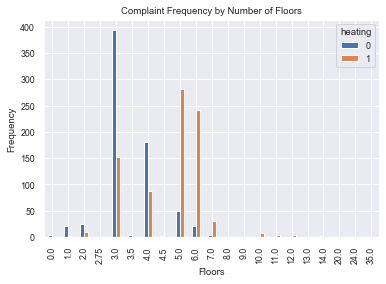

In [50]:
pd.crosstab(df_10031.numfloors,df_10031.heating).plot(kind='bar')
plt.title('Complaint Frequency by Number of Floors')
plt.xlabel('Floors')
plt.ylabel('Frequency')

__It looks like there are more heating complaints as the number of floors grows.__
__Number of floors looks like a relevant feature.__

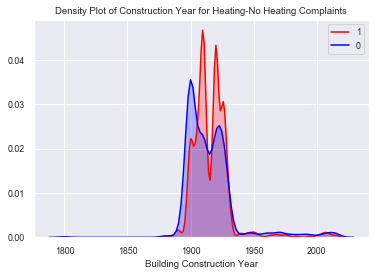

In [51]:
ax = sns.kdeplot(df_10031["yearbuilt"][df_10031.heating == 1], color="red", shade=True)
sns.kdeplot(df_10031["yearbuilt"][df_10031.heating == 0], color="blue", shade=True)
plt.legend(['1', '0'])
plt.title('Density Plot of Construction Year for Heating-No Heating Complaints')
ax.set(xlabel='Building Construction Year')
plt.show()

__It looks like for a certain range of building construction years it is more 'probable' to have a heating complaint vs not to have it.__

Text(0, 0.5, 'Frequency')

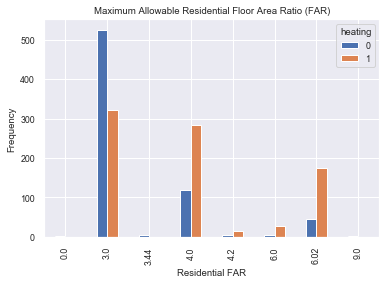

In [52]:
pd.crosstab(df_10031.residfar,df_10031.heating).plot(kind='bar')
plt.title('Maximum Allowable Residential Floor Area Ratio (FAR)')
plt.xlabel('Residential FAR')
plt.ylabel('Frequency')

__The max residential area grows, the more 'probable' it is to have a heating complaint.__

### (b) Correlation Table

In [53]:
df_correlation=df_pluto.corr()    #correlation table
df_correlation['abs'] = df_correlation['heating'].abs() #new column with absolute value of heating column
df_correlation=df_correlation[df_correlation.heating!=1]
df_correlation.sort_values(by=['abs'],ascending=False,inplace=True) #sorting by abs(correlation number)
df_correlation=df_correlation[['abs','heating']]   #just keeping the heating column and the abs value
df_correlation.head(12)

,abs,heating
residfar,0.277658,0.277658
facilfar,0.268505,0.268505
numfloors,0.220735,0.220735
bldgdepth,0.160847,0.160847
ycoord,0.145627,0.145627
borough_num,0.143222,0.143222
landuse,0.139820,0.139820
unitsres,0.119125,0.119125
unitstotal,0.113013,0.113013
resarea,0.112460,0.112460


__I don't see a very strong linear relationship between any variable but the columns that 'explain' more the addresses with heating complaints are:__
 - __residfar__: Maximum Allowable Residential Floor Area Ratio (FAR)
 - __facilfar__: The Maximum Allowable Facility Floor Area Ratio (FAR)
 - __numfloors__: Floors in the tallest building on the tax lot.
 - __bldgdepth__: The building’s depth, which is the effective perpendicular distance, measured in feet.<br><br>
*Features such as 'yearbuilt' didn't had a strong relationship as I though.*

### (c) Recursive Feature Elimination (RFE)

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In order to speed up the process I will be using only 5% of the dataset (choosing it randomly).
If you want to run it in your computer it is feasible, in mine it just takes a couple of minutes.

In [55]:
df_pluto['rand']=np.random.rand(df_pluto.shape[0],1)   #create random column with values between 0 and 1.
df_filter=df_pluto[df_pluto.rand<=0.05]   #This is how I control the amount of data. In this case 5%.
y_data = df_filter['heating']
x_data=df_filter.copy()
x_data.drop(['heating','address','borough','zonedist1','rand'], axis=1, inplace=True)   #remove non-numeric columns
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 16084
number of training samples: 24125


In [56]:
lr = LogisticRegression(solver='liblinear')
rfe = RFE(lr,1) #selecting 1 variable to see which one is more important.
rfe = rfe.fit(x_train, y_train)

In [57]:
print(rfe.ranking_)  #it gives the ranking of all the variables
predictions = rfe.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
print('\nBest feature: %s' % list(x_test.columns[rfe.support_]))

[15  8 30 25  4  6  7 26 22 29 27 11 13 14 21 20 23  9  1 28  3 17 18 10
 19 24  2 16 31  5 12]

Best feature: ['builtfar']


builtfar, according to the pluto dictionary, built floor area ratio.

In [58]:
#see all the rankings:
mapped = zip(x_train.columns, rfe.ranking_)
mapped=list(mapped)
list1=list()
for i in mapped:
    if i[1]<10:
        list1.append('0' + str(i[1]) + ' - ' +  i[0])
    else:
        list1.append(str(i[1]) + ' - ' +  i[0])
list1.sort()
print('Ranking of features according to RFE - Recursive Feature Elimination')
list1[0:10]

Ranking of features according to RFE - Recursive Feature Elimination


['01 - builtfar',
 '02 - residfar',
 '03 - facilfar',
 '04 - numfloors',
 '05 - borough_num',
 '06 - unitsres',
 '07 - unitstotal',
 '08 - landuse',
 '09 - bldgdepth',
 '10 - lotdepth']

According to RFE, this are the top 10 features. It makes sense since much has to do with the amount of residential or physical area and also the year it was constructed.

### (d) Random Forest Feature Importance

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
df_filter=df_pluto[df_pluto.rand<=0.05]   #This is how I control the amount of data. In this case 5%.
y_data = df_filter['heating']
x_data=df_filter.copy()
x_data.drop(['heating','address','borough','zonedist1','rand'], axis=1, inplace=True)   #remove non-numeric columns
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 16084
number of training samples: 24125


In [61]:
clf = RandomForestClassifier()
clf.fit(x_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [62]:
a=clf.feature_importances_
a=pd.Series(a)
a=a.to_frame()
a['variable']=pd.Series(x_train.columns)
a=a.sort_values(by=[0],ascending=False)
a.rename(columns={0:'total'},inplace=True)
a.reset_index(drop=True,inplace=True) #resetting index
print('\nTop 10 Features According to this Method')
a.head(10)


Top 10 Features According to this Method


,total,variable
0,0.097248,unitstotal
1,0.068690,resarea
2,0.065177,xcoord
3,0.064392,ycoord
4,0.060720,assessland
5,0.060239,assesstot
6,0.057849,builtfar
7,0.053549,bldgdepth
8,0.051390,lot
9,0.048309,bldgarea


### (e) XGBoost Feature Importance

In [63]:
from xgboost import XGBClassifier

In [64]:
#same as before, I will be using a small amount of the dataframe to speedup the results
df_filter=df_pluto[df_pluto.rand<=0.025]   #This is how I control the amount of data. In this case 2.5%.
y_data = df_filter['heating']
x_data=df_filter.copy()
x_data.drop(['heating','address','borough','zonedist1','rand'], axis=1, inplace=True)   #remove non-numeric columns
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 8080
number of training samples: 12120


In [65]:
model = XGBClassifier()
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
a=model.feature_importances_
a=pd.Series(a)
a=a.to_frame()
#print(a)
a['variable']=pd.Series(x_train.columns)
a.sort_values(by=[0],ascending=False,inplace=True)
#print(a)
a.rename(columns={0:'total'},inplace=True)
a.reset_index(drop=True,inplace=True) #resetting index
a.head(10)

,total,variable
0,0.313997,unitsres
1,0.137877,unitstotal
2,0.070030,residfar
3,0.046369,builtfar
4,0.035025,bldgdepth
5,0.031050,xcoord
6,0.029945,borough_num
7,0.027258,ycoord
8,0.024742,assesstot
9,0.022918,zipcode


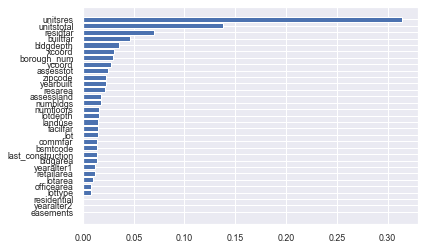

In [67]:
a.sort_values('total', ascending=True, inplace=True)
w=list(a['variable']) 
n=list(a['total']) 
plt.barh(range(len(w)),n) 
plt.yticks(range(len(w)),w) 
plt.show() 

__I ranked the top 10 features of each method (Corr(),RFE,Random Forest and XLBoost) and made a final list of features. I ranked them in the number of times they appeared in the 4 different ratings.__

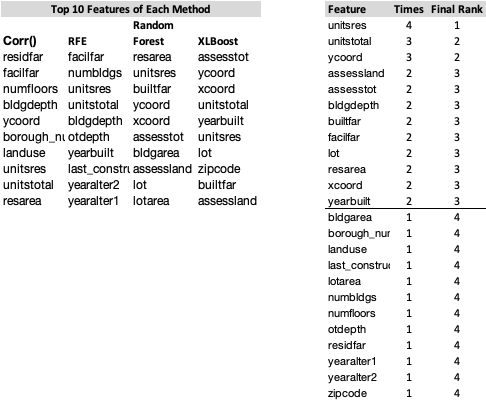

#### ANSWER: There are obvious relationships between heating complaints and some of the house characteristics. I can rank them to the following list:<br>
__Top Features - # of Times they Appeared in the 4 Different Rankings__<br>
unitsres (appeared 4 times)<br>
unitstotal (appeared 3 times)<br>
ycoord (appeared 3 times)<br>
assessland (appeared 2 times)<br>
assesstot (appeared 2 times)<br>
bldgdepth (appeared 2 times)<br>
builtfar (appeared 2 times)<br>
facilfar (appeared 2 times)<br>
lot (appeared 2 times)<br>
resarea (appeared 2 times)<br>
xcoord (appeared 2 times)<br>
yearbuilt (appeared 2 times)

### (4) Build a model that can predictive Heating complaints based on house/building characteristics<br>

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score 
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.metrics import f1_score
import itertools

In [69]:
#creating dataframes for precition/fit
y_data = df_pluto['heating']
#keeping only the variables that appeared in any of the rankings of previous question.
x_data=df_pluto[['unitsres','unitstotal','ycoord','assessland','assesstot','bldgdepth','builtfar','facilfar','lot','resarea','xcoord','yearbuilt','bldgarea','borough_num','landuse','last_construction','lotarea','numbldgs','numfloors','lotdepth','residfar','yearalter1','yearalter2','zipcode']]

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 319308
number of training samples: 478961


### Predictive Models
 - (a) Logistic Regression
 - (b) SVM (Support Vector Machine)

### (a) Logistic Regression
__I will be using 'Logistic Regression' because it is a good classification option when the target value is True or False or 1's and 0's.__

In [71]:
lr = LogisticRegression(solver='liblinear') 
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
#Evaluating accuracy:
predictions = lr.predict(x_test)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.8709553158705701

__The 0.87 value seems good (closer to 1 the better).__

In [73]:
#confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
pd.DataFrame(conf_matrix, columns=['Heating', 'No-Heating'], index=[['Heating', 'No-Heating']])

,Heating,No-Heating
Heating,275983,854
No-Heating,40351,2120


In [74]:
#same matrix as before but as a percentage, it seems better to read.
print('Confusion Matrix with Percents')
pd.DataFrame((conf_matrix/y_test.shape[0])*100, columns=['Heating', 'No-Heating'], index=[['Heating', 'No-Heating']])

Confusion Matrix with Percents


,Heating,No-Heating
Heating,86.431596,0.267453
No-Heating,12.637015,0.663936


__With cross validation we can make an out-of-sample testing to validate the accuracy results.__

In [75]:
#double checking with cross validation (5 folds)
scores = cross_val_score(lr, x_data, y_data, cv=5) 
np.mean(scores)

0.871228870765896

__Cross validation seems in line with accuracy measured before.__

### (b) SVM - Support Vector Machine

In [79]:
df_filter=df_pluto[df_pluto.rand<=0.0002]
y_data = df_filter['heating']
x_data=df_filter.copy()
x_data=df_filter[['unitsres','unitstotal','ycoord','assessland','assesstot','bldgdepth','builtfar','facilfar','lot','resarea','xcoord','yearbuilt']]
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.4, random_state=0) 
print("number of test samples :", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples : 60
number of training samples: 89


In [80]:
clf = svm.SVC(kernel='linear')
clf.fit(x_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [81]:
yhat = clf.predict(x_test)
print('f1 score:',f1_score(y_test, yhat, average='weighted')) 
accuracy = accuracy_score(y_test, yhat)
print('Accuracy:',accuracy)

f1 score: 0.7407407407407408
Accuracy: 0.8


#### Yes, we can use Logistic Regression for faster results or K Nearest Neighbors since they work faster than SVM with almost the same results.